<center><center>
    
# Defect detection in electroluminescence images of solar modules
    
## W281 Computer Vision Final Project 

### Aswin Thiruvengadam, Alexander To, Andi Morey Peterson, and Dan Ortiz

## Abstract

The detection of anomalies and defects within images is an important application of computer vision for manufacturers and researchers. It enables fast, repeatable, and automated identification and measurement of defects. In this project, we developed techniques to identify common manufacturing defects found in electroluminescence solar modules and solar cell images, taken from a commercial manufacturing line and made publicly available for research and development.    

Electroluminescence (EL) is a physical property of semiconductor materials whereby photons are emitted from the bulk semiconductor material as a result of radiative recombination induced by an applied external electric field. This process is commonly used in digital watches and car dashboards for night time display illumination. It is also used as an imaging and inspection technique in solar cell manufacturing as the map of radiative recombination across the device can reveal manufacturing defects in the solar cell and/or module not visible to the human eye. The purpose of this project is to  analyze EL images of silicon solar cells in order to detect and classify common defects discovered in production.

A multi-class classifier was built by scoring the output of 6 separate binary classifiers, trained to detect whether a particular defect class was present in the given image or not. This was a particularly challenging task since:

- the images had multiple defect classes per image.
- the dataset was poorly organized, annotated incorrectly, and some classes were not distinct enough to warrant separate classes (for instance closed, isolated and resistive cracks). 
- the images were inconsistently cropped and featured two types of wafer material (muticrystalline vs monocrystalline), which introduced features difficult to distinguish from defect instances. 

Nevertheless, in this work an attempt was made to overcome the data issues. Over 10,000 images were reviewed, and over 2000 images were identified and removed as having false or incorrect annotations. Since every image could not be fully verified, the report presents two comparisons throughout:

- The single defect identification vs a non-defected cell. 
- The single defect identification vs. all other classes. 

This can be thought of loosely as the upper and lower bounds of the classifier given our constraints due to poor data quality. Since the classification versus a clean cell is arguably the simplest classification task since the clean cell can be thought of as the 'ground truth' image, free of any defects. The more complicated classification task is to distinguish against all other defect classes, and hence this serves as the 'lower bound' on performance.

The best classifier for each defect class is summarized below:

<span style="color:red">**TODO: Need to fill in final results.**</span>



| Defect Class                                  | Transforms                   | Classifier Model             | Balanced Accuracy Score (Test Data) vs. Clean | Balanced Accuracy Score (Test Data) vs. All Others  |
|-----------------------------------------------|------------------------------|------------------------------|-----------------------------------------------|-----------------------------------------------------|
| Closed Cracks                                 | Sato Vesselness Filter, PCA  | Gradient Boosting Classifier | 77.9/82.8                                     |  68.2/74.5                                          |
| Isolated Cracks                               | Gaussian Blur,  PCA          | Gradient Boosting Classifier | 82.8/88.7                                     |  66.0/80.6                                          |
| Resistive Cracks                              | Bussbar removal, FFT Butterworth Bandpass, PCA          |  Extra Trees Classifier                | 72.8/80.6                                     |           /82.3                                          |
| Bright Spots                                  | Gaussian Blur,  Fourier Transform | Logistic Regression         | 96.7/99.4                                     | 93.4/98.3                                         |
| Corrosion                                     | PCA / Eigenface, Cosine Similarity | Logistic Regression          | 99.5/100.0                                    | 100.0/100.0                                       |
| Front Grid Interruptions and Near Solder Pads | Sobel Filter                 | Gradient Boosting Classifier     | 64.3/70.2                                     | 67.3/74.7                                         |

Our overall balanced accuracy score is

| Defect Class                                  | Balanced Accuracy Score (Test Data) vs. Clean | Balanced Accuracy Score (Test Data) vs. All Others  |
|-----------------------------------------------|-----------------------------------------------|-----------------------------------------------------|
| Complete Classifier                           | 76.9/80.7                                     |        76.9/80.7                                             |


Whilst we feel that stronger performance is likely obtainable with cleaner data, we were not able to fully verify all images in the dataset and we were therefore unable to fully verify this claim.

Future approaches to improve the classifier could focus on isolation of the cell from the cell boarders to overcome the issue of the border edge confusing the classifier. Similarly, methods of distinguishing the darker clusters due to multicrystalline texture will help with more accuracte thresholding and crack detection techniques. 

A more successful approach may be to approach the task as an object detection problem, which seeks to place bounding boxes around the image. Alternatively, a 'ground truth' image estimation and subtraction may also be an effective approach to highlight anomolies, which can then be separately classified using the filters developed herein. 

## The Data

Our dataset consists of a publicly available dataset of 16,808 real and 256 simulated images of solar cells (17,064 individual images in total), sourced from 368 full module images via cropping. The 16,808 real images are taken from a publicly available dataset, which was recently published as part of a study of various semantic segmentation models used to highlight the defective regions within each image, where present. Some summary details of the dataset are provided below.
    
The images were captured using either a 16 MM CMOS sensor with a 950 nm long-pass filter, or a 8 MP Si CCD sensor with 850 nm long-pass filter. The long pass filter is used to filter any background signal unrelated to the radiative emission from the sample.

Each image is in jpeg format with each cropped cell having dimension 406 x 406 pixels. As EL images measure ‘counts’, there are no color channels to these images as each image is effectively a map of luminescent intensity.  

A publicly available fork of the original repository can be accessed from:
https://github.com/atox120/UCF-EL-Defect

<span style="color:red">**TODO: Need to describe how we modified the images here.**</span>


#### A note on dataset quality. 

Unfortunately, significant issues with the dataset quality were identified, which complicated the initial EDA, feature development and development of classifiers (as models trained poorly on the mislabelled instances). As a result, the team undertook significant review of the dataset, in order rectify the common issues experienced such as:

1. Mislabelled defects, whereby a defect was labeled with the incorrect label.
2. Missing labels of defects which were present. 

The following list is a summary of the number of files reviewed and corrections made per class:

- Non Defected: 5237 Images reviewed, 779 false instances removed. 
- Resistive Cracks: 3088 Images reviewed, 485 false instances removed. 
- Closed Cracks: 2641 Images reviewed, 584 false instances removed. 
- Bright Spot: 248 Images reviewed, 68 false instances removed. 
- Corrosion: 68 Images reviewed, 28 false instances removed. 
- Isolated Cracks: 1756 Images reviewed, 436 false instances removed. 
- Front Grid Interruptions/Near Solder Pad: 1570 images verified images. 

A summary of the final number of instances per defect class is shown below:

## The Defects

In [1]:
import os
import sys
import copy
import time
import numpy as np
sys.path.append(os.path.join(os.path.abspath(""), ".."))
import matplotlib.pyplot as plt

from app.utils import ImageWrapper
from app.custom import RemoveBusBars, Orient
from app.transforms import FFT, IFFT, CreateOnesMask, PCA, MaskedFFT, DownsampleBlur, Butterworth
from app.filters import CreateKernel, Convolve, Canny, HOG, Sato, ThresholdMultiotsu
from app.imager import ImageLoader, DefectViewer, Show, Exposure

In [2]:
def show_example_image(defect_class='None', seed=0):
    """ Function to load and display a few images. Wraps the underlying classes"""
    
    # Load images
    iml = ImageLoader()
    defect_categories = iml.defect_classes
    # Filter out the not required defect categories
    not_defect_class = [x for x in defect_categories if x != defect_class]
    
    # Load defect instances, all other instances, and clean samples
    defects = (DefectViewer() << (ImageLoader(defect_class=defect_class) << 10))
    all_others = (DefectViewer() << (ImageLoader(defect_class=not_defect_class) << 10))
    clean = (DefectViewer() << (ImageLoader(defect_class='None') << 10))
    
    # Step to remove any files in the defect class with multiple annotations in the all_others class
    # This is so that the same filename cannot exist in the defect and the all others class, which 
    # would confuse a classifier. 
    single_defect = defects - all_others

    _ = Show(num_images=1, seed=seed) << single_defect
    
    return

The below code shows the final number of unique files per class in the cleaned up dataset.

In [3]:
# Instantiate class
iml = ImageLoader()
_ = iml.load_n(1) # Load a token image, in order to create the main df
#Remove defects not used in this sample
defects_df = iml.final_samples
defects_df = defects_df[defects_df['defect_class'] != 'Unknown']
defects_df = defects_df[defects_df['defect_class'] != 'BeltMarks']
defects_df = defects_df[defects_df['defect_class'] != 'Disconnected']
defects_df = defects_df[defects_df['defect_class'] != 'HighlyResistive']
defects_df.groupby(['defect_class']).agg('count')['filename'].reset_index()

,defect_class,filename
0,BrightSpot,58
1,Closed,943
2,Corrosion,28
3,FrontGridInterruption,406
4,Isolated,357
5,NearSolderPad,3602
6,None,3243
7,Resistive,977



### Front Grid Interruption and Near Solder Pad

The Front Grid Interruption defect is best described as "darkened rectangles appearing along the printed metal fingers". These are caused where by a break in current flow along the finger, and the location of the break determines the classification. 

Near Solder Pad defects are very similar to Front Grid Interruption; however, these rectangles have a shaded region adjacent to the busbar and are caused by a different mechanism.A front grid interruption occurs in between the busbar region, and is caused by for instance contamination during processing. This issue presents as a darkened vertical line and are treated as a combined class in this work. 

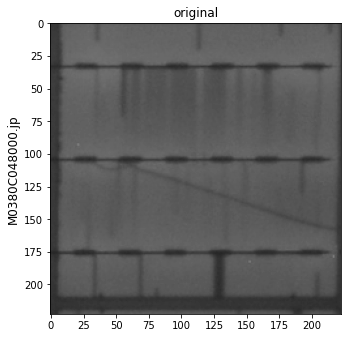

In [4]:
show_example_image(['FrontGridInterruption', 'NearSolderPad'], seed=16)

### Corrosion
Corrosion defects present as darkened regions starting at the busbar and extending perpendicularly along the finger, and typically extending farther from the centre than at the edges of the contact. Corrosion occurs due to moisture ingress into the encapsulated module, and is usually a result of accelerated environmental degradation testing, or exposure in the field.

Corrosion presents a unique pattern in the centre of the cell, as is shown below.

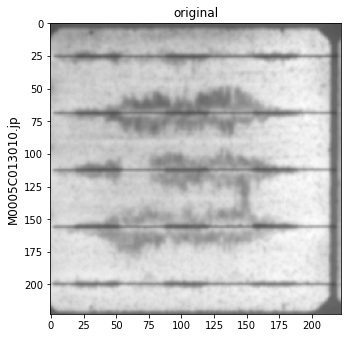

In [5]:
show_example_image('Corrosion', seed=1)

### Highly Resistive
Highly resistive interconnects are bright along portions of the busbar, and darkened along others. The longer the resistive region, the brighter the extended region perpendicular to the busbar, since the same amount of source current is not concentrated in a smaller area. Due to time limitations, this particularly large class was not able to reviewed for labelling accuracy, and so was omitted. 

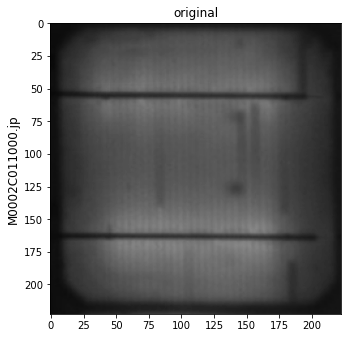

In [6]:
show_example_image('HighlyResistive', seed=1)

### Bright Spot
Bright spots are caused by concentrated regions of current flow due to other regions of the cell being highly resistive, likely due to poor contact formation, which results in the brighter regions having better contact than the adjacent regions. 

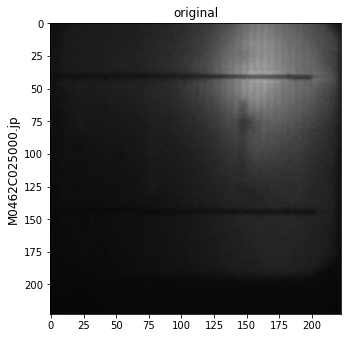

In [7]:
show_example_image('BrightSpot', seed=1)

### Resistive Cracks
Resistive crack category is one of three types of crack defects. This crack, resistive cracks, is determined by darkened regions extending from closed crack line or have a gradient intensity which is darkest at the crack edge. These are caused by cracks which partially isolate current flow in that region, hence the darkened appearance. 

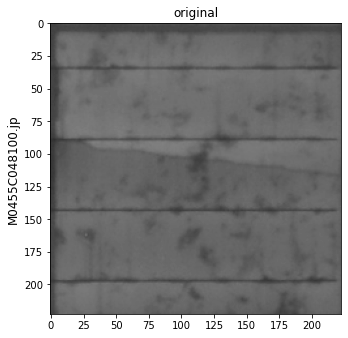

In [8]:
show_example_image('Resistive', seed=2)

### Closed Cracks
Closed cracks thin dark crack lines. They do not necessarily obstruct current flow into the bulk material, hence no darkened gradient extends from the crack line. However since the exposed crack edge is highly re-combinative, no luminescence occurs in these regions and hence they appear as thin dark lines.

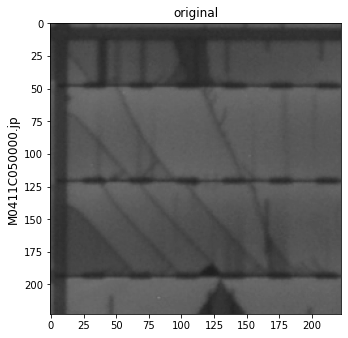

In [9]:
show_example_image('Closed', seed=4)

### Isolated Cracks
Isolated cracks are cracks which separate/isolate two individual sections of the cell with darkened regions extending from the crack. They also have a uniform intensity across the darkened regions. These occur during mishandling, which results in a cleaving of the wafer material which creates a complete electrical isolation of the cracked wafer. 

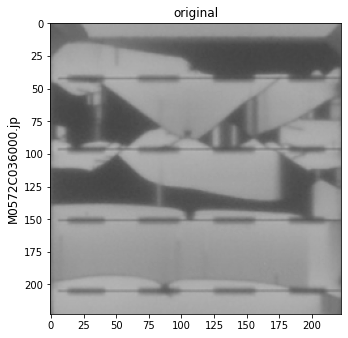

In [10]:
show_example_image('Isolated', seed=9)

In the previous analysis, a few examples of cracks with multiple instances per image were shown. Since we did not aim to filter the dataset to having image with only one defect type present (since this would entail too much specialised expertise/domain knowledge to correctly identify the crack and time), it is likely our model training suffered from being shown multiple defects per image, but not being able to attribute these to their correct classes. 

### No Defects
Below is a sample image of a solor cell with no visual defects that supplied as our ground truth.

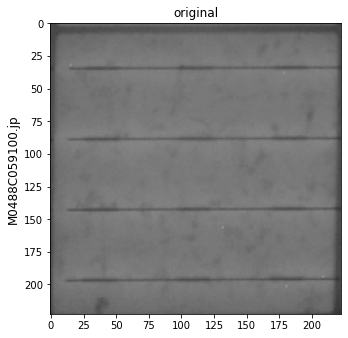

In [10]:
show_example_image('None', seed=2)

## Feature Detection

The approach for feature detection for this project was to treat every defect as a separate feature and a unique feature detection algorithm would be deployed as such.  It is worth noting that this was a trial and error process and this report only contains the final detectors selected prior to classification. Detail code for the selected algorithms can be found in the `notebooks` folder with files starting with `eda_`.  This report offers no commentary on what algorithms did not achieve desirable results, and those reports can be found in the `notebooks/99_archive` folder.

To make this report easier to read, and to make each model and algorithm to execute similarly, a common code base was written for this project and can be found in the `app` folder.  This code was written in a way that algorithms can chain transformations for several hundred or thousand images into short code blocks. 


### Front Grid Interruptions and Near Solder Pad

As descripted in the data section of this report, there was many images that are no annotated correctly (i.e. they were incorrectly labeled) and the defects Front Grid Interruptions and Near Solder Pad suffered this issue the most.  This is likely due to how similar they are in nature; even humans have a hard time categorizing these defects.  Therefore, for this project, the two defects were combined and the model will now give a binary response for: "Yes - This image contains a front grid interruption or near solder pad or both" versus "No - this image does not contain a front grid interruption or near solder pad defect."  

For feature detection - several methodologies were used, such as a simple edge detection kernel, kanny filters, and a Fourier transform (to detect specific frequencies of these defects).  However, none proved to be better models than the sobel filter as shown below. 

For the full eda, model evaluation and analysis, please see the `eda_frontgrid.ipynb` and `eda_nearsolderpad.ipynb` notebooks.

Text(0.5, 1.0, 'After Sobel Filter')

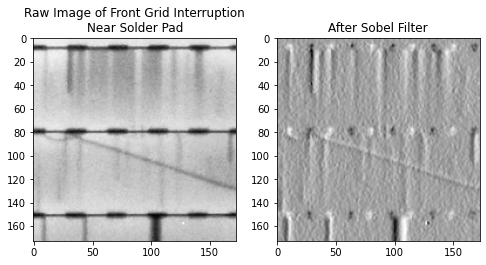

In [11]:
# Grab Images
fgi_defect_classes = ['FrontGridInterruption', 'NearSolderPad']
fgi_nsp_defect = (DefectViewer(row_chop=25, col_chop=25) << (ImageLoader(defect_class=fgi_defect_classes) << 10))
#fgi_nsp_defect.category = fgi_defect_classes

# Orient and run through Sobel Filter on Axis 0
fgi_nsp_defect_oriented = Orient(num_jobs=2) <<fgi_nsp_defect
defect_kernel = CreateKernel(kernel='sobel', axis=0) << fgi_nsp_defect_oriented
fgi_nsp_sobel = Convolve() << defect_kernel

# Plot images
plt.figure(figsize=(8, 15))
plt.subplot(121)
plt.imshow(fgi_nsp_defect.images[6], cmap='Greys_r')
plt.title("Raw Image of Front Grid Interruption\nNear Solder Pad", size=12)
plt.subplot(122)
plt.imshow(fgi_nsp_sobel[1].images[6], cmap='Greys_r')
plt.title("After Sobel Filter", size=12)


### Corrosion

Due to the similar nature of the corrosion defect from one image to the other, and because it occurs on all of the busbars when the defect occurs, removing the busbars was not recommended.  Instead, a Principal Component Analysis was completed to possibly reduce dimensions. 

For the full eda, model evaluation and analysis, please see the `eda_corrosion.ipynb` notebook.

20 principal components explain 98.90 % of the total variance


Text(0, 0.5, 'Cumlative Explained Variance %')

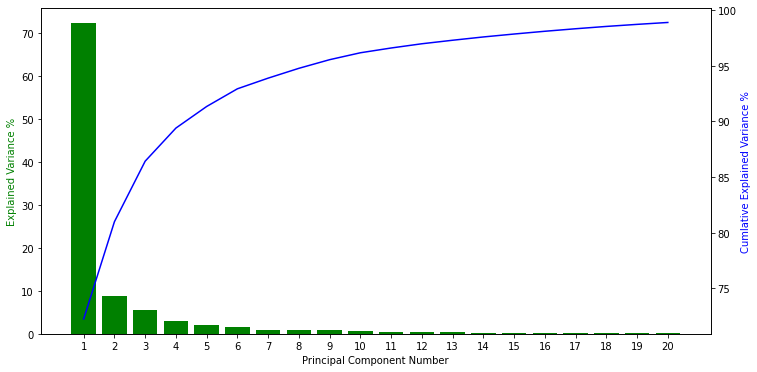

In [12]:
# Run PCA analysis on 20 components and plot the variance
n_components = 20
PCA_class_defect = PCA(transpose=True, n_components=n_components, whiten=True)

corrosion_defect_class='Corrosion'
corrosion_defect = (DefectViewer(row_chop=25, col_chop=25) << (ImageLoader(defect_class=corrosion_defect_class) << 50))
corrosion_defect.category = corrosion_defect_class
clean = Orient(num_jobs=2) << (DefectViewer(row_chop=25, col_chop=25) << (ImageLoader(defect_class='None') << 50))

# calculate the transform on the images
PCA_class_defect << corrosion_defect

# Total explained Variance
exp_var = PCA_class_defect.explained_variance_ratio[0]
total_exp_var = np.sum(exp_var)
print(f'{n_components} principal components explain {total_exp_var * 100:.2f} % of the total variance')

# Plot 
# Define X axis intervals:
x=np.arange(1, n_components + 1)
# Cumulative variance:
y1 = exp_var * 100
y2 = np.cumsum(y1)
    
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.bar(x, y1, color = 'g')
ax2.plot(x, y2, color = 'b')
    
ax1.set_xlabel('Principal Component Number')
ax1.set_xticks(x)
    
ax1.set_ylabel('Explained Variance %', color='g')
ax2.set_ylabel('Cumlative Explained Variance %', color='b')


Because the first component explained over 70% of the variance of the corrosion images, a cosine simialarity analysis was completed. 

Average Corroded Cell
Average of scores for 1st component defected images:
-1.00658


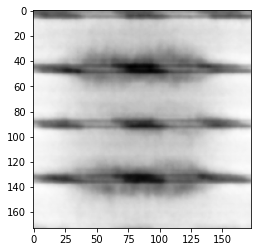

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

def get_cosine_similarity(template, img_array):
    """ Returns the cosine similarity of the top N eigenfaces.""" 
    
    #Get dims
    N, H, W = img_array.images.shape
    #Reshape images
    reshaped = img_array.images.reshape(N, H * W)
    # Reshape template
    stacked_face = template.reshape(len(template), H*W)
    # Calculate similarity
    sim_scores = cosine_similarity(stacked_face, reshaped)

    sim_scores = np.sum(np.asarray(sim_scores), axis=0) #Sum all PCA components for each image

    return sim_scores

eigenfaces = PCA_class_defect.eigenfaces[0]
sim_scores_clean = get_cosine_similarity(eigenfaces, clean[-1])
sim_scores_defect = get_cosine_similarity(eigenfaces, corrosion_defect)

# Calculate the average of all images within each category. 
average_corrosion = np.mean(corrosion_defect.images, axis=0)
print('Average Corroded Cell')
plt.imshow(average_corrosion, cmap='Greys_r')

print("Average of scores for 1st component defected images:")
print(round(np.mean(sim_scores_defect),5))


Average Clean Cell
Average of scores for 1st component for clean images:
-1.04665


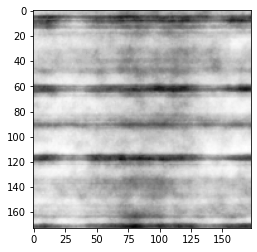

In [14]:
# Calculate the average of all images within each category. 
average_clean = np.mean(clean[-1].images, axis=0)
print('Average Clean Cell')
plt.imshow(average_clean, cmap='Greys_r')

print("Average of scores for 1st component for clean images:")
print(round(np.mean(sim_scores_clean),5))

### Bright Spot

There are many options in Bright Spot feature detection - due to the high contrast nature of the spots in comparison to the background image of the solar cell. One method developed was to do a Fourier transform of the images extract the bright spot feature. 

For the full eda, model evaluation and analysis, please see the `eda_brightspot.ipynb` notebook.

Text(0.5, 1.0, 'Fourier Transform')

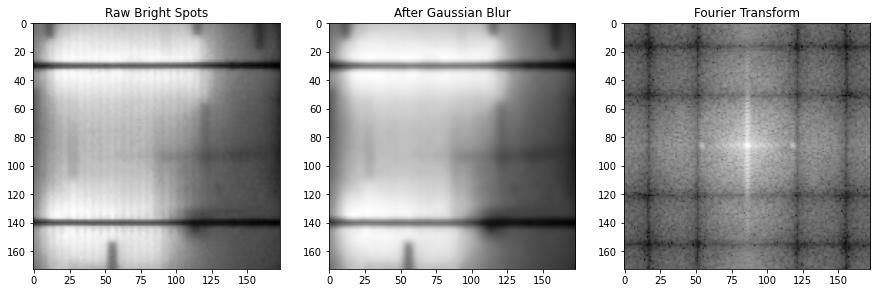

In [15]:
# Grab Brightspot Images
brightspot_defect_class='BrightSpot'
brightspot_defect = (DefectViewer(row_chop=25, col_chop=25) << (ImageLoader(defect_class=brightspot_defect_class) << 10))
brightspot_defect.category = brightspot_defect_class

# Mean Exposure and run a Gaussian Blur
brightspot_defect_blur = Convolve() << (CreateKernel(dim=2, kernel='gaussian', size=5, std=8) << (Exposure('mean_norm') << brightspot_defect))
fourier_defect = (FFT(dim=2) << brightspot_defect_blur) 

# Plot images
plt.figure(figsize=(15, 24))
plt.subplot(131)
plt.imshow(brightspot_defect.images[1], cmap='Greys_r')
plt.title("Raw Bright Spots", size=12)
plt.subplot(132)
plt.imshow(brightspot_defect_blur[1].images[1], cmap='Greys_r')
plt.title("After Gaussian Blur", size=12)
plt.subplot(133)
plt.imshow(fourier_defect[-2].images[1], cmap='Greys_r')
plt.title("Fourier Transform", size=12)

### Resistive Cracks
Resistive cracks have both a crack (high frequency component) and a color gradient (low frequency component). These features required the reduction of noise while enhancing these features for the classifier. The following steps were taken to process the images.

- Removal of Bus bars: This was done…..
- Application of Butterworth Band pass filter in Fourier space: This was done...
- Application of Mask when taking the inverse of Fourier space: This was done…

After image processing, multiple different classifiers were assessed manually and the images were passed through tpot to identify any other high potential classifiers. Depending on the run, both the CNN and the Extra Tree Classifier yielded the best performance.

Note: For the full eda, model evaluation and analysis, please see the `eda_resistive.ipynb` notebook.


Feature Detection Used in Final Model


Text(0.5, 1.0, 'Fully Processed Image')

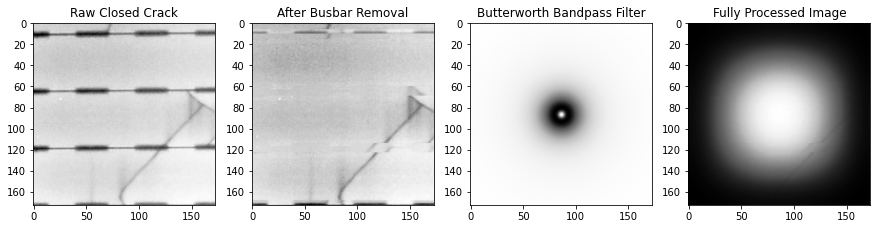

In [16]:
## Grab the Resistive defects
n_samples = 10
seed = 1234
defect = (DefectViewer(row_chop=25, col_chop=25) << (ImageLoader(defect_class='Resistive') << n_samples))
defect.category = 'Resistive'

## Orienting and removing busbars
oriented_defect = Orient(num_jobs=20) << defect
nobus_defect = RemoveBusBars() << oriented_defect

## Generating Butterworth Bandpass Filter
x = nobus_defect[-1]
btw = Butterworth(((~x)[0]))
mask = btw.bandpass(3, 15, 1, 1)

## Applying the band pass filter during the transformation
f = FFT(dim=2) << nobus_defect
iff = IFFT(mask) << f 

# Plot images
print("Feature Detection Used in Final Model")
plt.figure(figsize=(15, 24))
plt.subplot(141)
plt.imshow(defect.images[0], cmap='Greys_r')
plt.title("Raw Closed Crack", size=12)
plt.subplot(142)
plt.imshow((~(nobus_defect)[1])[0], cmap='Greys_r')
plt.title("After Busbar Removal", size=12)
plt.subplot(143)
plt.imshow(mask, cmap='Greys_r')
plt.title("Butterworth Bandpass Filter", size=12)
plt.subplot(144)
plt.imshow((~(iff[-1]))[0], cmap='Greys_r')
plt.title("Fully Processed Image", size=12)

### Closed Cracks
Various filters and filtering algorithms were trialled to isolate closed cracks. These include:

- Applying a sato vesselness filter to highlight cracks
- Thresholding the image, to remove lower strength signals, and to accentuate the cracks from the background.
- Applying a cross shaped mask to the FFT magnitude and then transforming the image back to remove busbars and vertical lines. 

Chained sequences of these filters/transforms were applied, see below as examples.

Note:  For the full eda, model evaluation and analysis, please see the `eda_closed.ipynb` notebook.

Feature Detection Used in Final Model


Text(0.5, 1.0, 'After Multi Otsu Threshold')

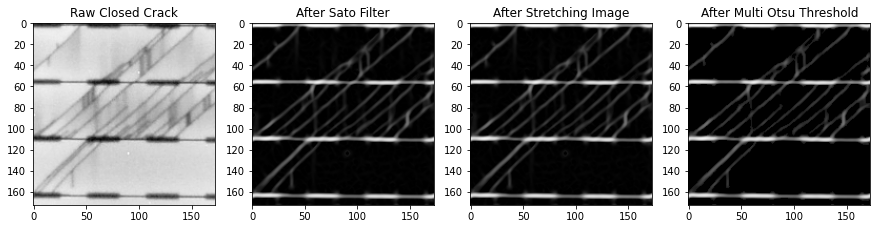

In [17]:
# Grab Closed Crack Images
closed_defect_class='Closed'
closed_defect = (DefectViewer(row_chop=25, col_chop=25) << (ImageLoader(defect_class=closed_defect_class) << 10))
closed_defect.category = closed_defect_class

# Apply Sato Filter and threshold image
_, sato = (Sato(sigmas=[1,2]) <<  closed_defect)
_, sato_stretch = Exposure('stretch') << sato
images = ThresholdMultiotsu(classes=4, threshold=1, digitize=False) << sato_stretch

# Plot images
print("Feature Detection Used in Final Model")
plt.figure(figsize=(15, 24))
plt.subplot(141)
plt.imshow(closed_defect.images[2], cmap='Greys_r')
plt.title("Raw Closed Crack", size=12)
plt.subplot(142)
plt.imshow(sato.images[2], cmap='Greys_r')
plt.title("After Sato Filter", size=12)
plt.subplot(143)
plt.imshow(sato_stretch.images[2], cmap='Greys_r')
plt.title("After Stretching Image", size=12)
plt.subplot(144)
plt.imshow(images[1].images[2], cmap='Greys_r')
plt.title("After Multi Otsu Threshold", size=12)


Applying FFT detection - Not used as didn't provide better results on training data


Text(0.5, 1.0, 'After Cross Filter')

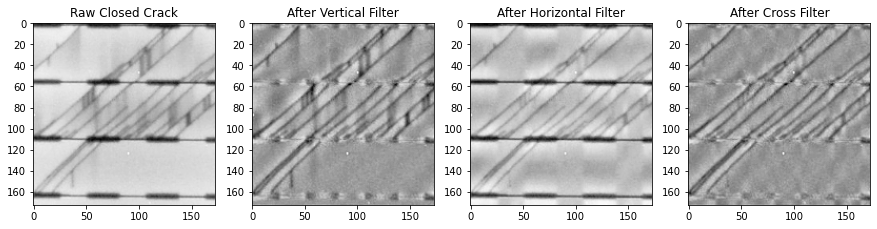

In [18]:
import cv2

# Function to make masks
def create_mask(half_width, shape, mtype):
    
  # Create a vertical mask
    if mtype == 'vertical':
        in_mask = np.zeros(shape)
        midpoint = in_mask.shape[1] // 2
        top_left = (midpoint - half_width, 0)
        bottom_right = (midpoint + half_width, shape[0])
        cv2.rectangle(in_mask, top_left, bottom_right, (255, 255, 255), -1)[0]
        in_mask = in_mask / 255
        
  # Create a horizontal mask
    if mtype == 'horizontal':
        in_mask = np.zeros(shape)
        midpoint = in_mask.shape[0] // 2
        top_left = (0, midpoint - half_width)
        bottom_right = (shape[1], midpoint + half_width)
        cv2.rectangle(in_mask, top_left, bottom_right, (255, 255, 255), -1)[0]
        in_mask = in_mask / 255
        
    return in_mask

print("Applying FFT detection - Not used as didn't provide better results on training data")
# Apply maks to FFT transformed image

# Make masks
vertical = 1 - create_mask(4, closed_defect.images[0].shape,'vertical')
horizontal = 1 - create_mask(4, closed_defect.images[0].shape,'horizontal')
cross = vertical + horizontal - 1
cross[cross < 1] = 0
_, vertical_ = (Exposure('mean_norm') << (MaskedFFT(mask=vertical, window=False) << closed_defect))
_, horizontal_ = (Exposure('mean_norm') <<(MaskedFFT(mask=horizontal, window=False) << closed_defect))
_, cross_ = (Exposure('mean_norm') << (MaskedFFT(mask=cross, window=False) << closed_defect))

# Plot images
plt.figure(figsize=(15, 24))
plt.subplot(141)
plt.imshow(closed_defect.images[2], cmap='Greys_r')
plt.title("Raw Closed Crack", size=12)
plt.subplot(142)
plt.imshow(vertical_.images[2], cmap='Greys_r')
plt.title("After Vertical Filter", size=12)
plt.subplot(143)
plt.imshow(horizontal_.images[2], cmap='Greys_r')
plt.title("After Horizontal Filter", size=12)
plt.subplot(144)
plt.imshow(cross_.images[2], cmap='Greys_r')
plt.title("After Cross Filter", size=12)


### Isolated Cracks

Various filters and filtering algorithms were trialled to highlight isolated cracks. These include:

- Blurring the image, to remove thin lines - such as closed cracks. 
- Thresholding the image, to highlight the dark regions created by the isolated cracks. 
- Using a farid filter and a peak finding algorithm to mask out dark regions created by busbars. 

Chained sequences of these filters/transforms were applied,

For the full eda, model evaluation and analysis, please see the 'eda_isolated.ipynb' notebook. 
The summary from that notebook is copied below.

Feature Detection Used in Final Model


Text(0.5, 1.0, 'After Downsample Blur')

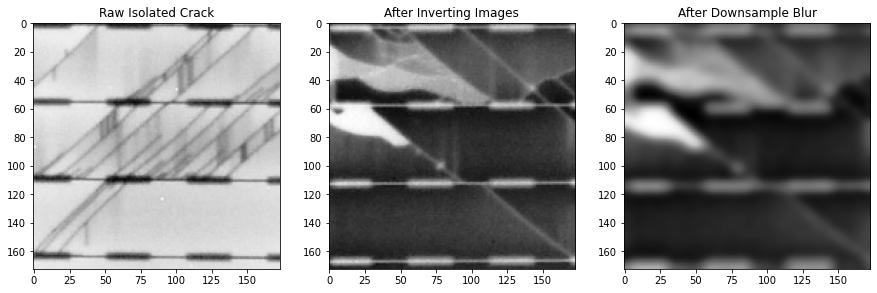

In [19]:
from app.transforms import FFT, IFFT, CreateOnesMask, PCA, DownsampleBlur, MaskedFFT

# Grab Isolated Crack Images
isolated_defect_class='Isolated'
isolated_defect = (DefectViewer(row_chop=25, col_chop=25) << (ImageLoader(defect_class=isolated_defect_class) << 10))
isolated_defect.category = isolated_defect_class

# Invert Images
original, inverted = Exposure('invert') << isolated_defect

#Apply Downsample Blur
inverted_blurred =  Exposure('invert') << (DownsampleBlur(sigma=3, size=17) << isolated_defect)

# Plot images
print("Feature Detection Used in Final Model")
plt.figure(figsize=(15, 24))
plt.subplot(131)
plt.imshow(closed_defect.images[2], cmap='Greys_r')
plt.title("Raw Isolated Crack", size=12)
plt.subplot(132)
plt.imshow(inverted.images[2], cmap='Greys_r')
plt.title("After Inverting Images", size=12)
plt.subplot(133)
plt.imshow(inverted_blurred[-1].images[2], cmap='Greys_r')
plt.title("After Downsample Blur", size=12)

# Classification Models

<span style="color:red">**TODO: Describe Our Methodolgoy to Classifying Models**</span>

In [20]:
from app.models import Classifier
from app.model_features import grid_interruption, brightspots, closed, isolated, get_samples
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

### Front Grid Interruption and Near Solder Pads

In [23]:
num_samples = 2000
fgi_defect_classes = ['FrontGridInterruption', 'NearSolderPad']
fgi_defect, not_fgi = get_samples(fgi_defect_classes, num_samples, complimentary=True)

In [24]:
# Base model on raw data
title = 'Base model Front Grid Interruption / Near Solder Pad vs. No FGI or NSP'
model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': None, 'max_iter' : 100}
cla = Classifier(fgi_defect, not_fgi, LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(title, " ", score)

Base model Front Grid Interruption / Near Solder Pad vs. No FGI or NSP   0.6794054405440544


/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [26]:
# Train a Gradient boosted classifier
title = 'Graidient Boosted Classifier: Front Grid Interruption / Near Solder Pad vs. No FGI or NSP'
pca_dims = min(100, num_samples)
params = {'seed': 14376,'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.05, 'pca_dims': pca_dims}
cla = Classifier(fgi_defect, not_fgi, GradientBoostingClassifier, None)
     
# When done, return the score 
score = cla.fit_cv(**params)
print(title, " ", score)

Graidient Boosted Classifier: Front Grid Interruption / Near Solder Pad vs. No FGI or NSP   0.6986795956261606


Results vs Clean:

| **Front Grid Int. / Near Solder vs Clean**   | **Best Score**      | **Transform** |
|---------------------|------------------------|----------:|
| Logistic Regression | None                   |  67    | 
| Gradient Boosting Classifier | PCA           |  78    |
| Gradient Boosting Classifier | PCA + Sobel   |  79    |
| CNN                 | PCA + Sobel  | **79.5** |



Results vs all other defects:

| **Front Grid Int. / Near Solder vs All Others**   | **Best Score**      | **Transform** |
|---------------------|------------------------|----------:|
| Logistic Regression | None                   |  65    | 
| Gradient Boosting Classifier | PCA           |  67    |
| Gradient Boosting Classifier | PCA + Sobel   |  **73**    |
| CNN                 | PCA + Sobel  | 66 |


Despite the high expetation of performance of the CNN, the final classifier selected for the final model is the gradient boosting classifier, with PCA + Sobel filtering. When compared with other defect classes, the CNN did not outperform other classifiers.

For more detailed code on these trial runs see `eda_frontgrid.ipynb`. 

### Bright Spots


With this type of defect, and its sharp contrast, a baseline classifier was building using raw images in which images with defect was compared with images without the defect (including images with other major defects).  Because of its good performance, only one other classifier was constructed -- a logistics regrestion classifier:

In [28]:
# Convert the data to the required format for grid interruption
fgi_defect_ = grid_interruption(fgi_defect, num_jobs=2)
not_fgi_ = grid_interruption(not_fgi, num_jobs=2)

Process Process-20:
Process Process-19:
Traceback (most recent call last):
Exception in thread Thread-0:
Traceback (most recent call last):
  File "/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/home/dan/Documents/git/w281_finalproject_solascan/notebooks/../app/utils.py", line 156, in run
    self.results = self.func(*self.args)
  File "/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/multiprocessing/connection.py", line 383, in _recv
    raise EOFError
EOFError



KeyboardInterrupt: 

  File "/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dan/Documents/git/w281_finalproject_solascan/notebooks/../app/utils.py", line 174, in parallel_wrapper
    retval = func(*args)
  File "/home/dan/Documents/git/w281_finalproject_solascan/notebooks/../app/filters.py", line 489, in apply_filter
    out_list = [sk_hog(x, **self.params)[1] for x in in_imgs]
  File "/home/dan/Documents/git/w281_finalproject_solascan/notebooks/../app/filters.py", line 489, in <listcomp>
    out_list = [sk_hog(x, **self.params)[1] for x in in_imgs]
  File "/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/skimage/_shared/utils.py", line 394, in fixed_func
    return func(*args, **kwargs)
  File "/home/dan/anaconda3/envs/w281_final_project

In [ ]:
num_samples = 250
defect_classes = ['BrightSpot']
brightspot_defect, not_brightspot = get_samples(defect_classes, num_samples, complimentary=True)

In [27]:
# Base model on raw data
title = 'Base model Bright Spots vs. No Bright Spots'
model_params = {'penalty': 'l2', 'seed': 1234, 'pca_dims': None, 'max_iter' : 500}
cla = Classifier(brightspot_defect, not_brightspot, LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(title, " ", score)

Base model Bright Spots vs. No Bright Spots   0.9343715239154616


In [28]:
title = 'After Gaussian blur and Fourier Bright Spots vs. No Bright Spots'
brightspot_ = brightspots(brightspot_defect, num_jobs=20)
not_brightspot_ = brightspots(not_brightspot, num_jobs=20)
cla = Classifier(brightspot_, not_brightspot_, LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(title, " ", score)

0 were rejected
0 were rejected
After Gaussian blur and Fourier Bright Spots vs. No Bright Spots   0.9827586206896552


Bright spots, with raw data, was already predicting high on train data (>93% accuracy).  The feature detection of using Gaussian blur and Fourier analysis was not necessiary though does do better than the raw analysis.  

Results vs all other defects:

| **Brightspots vs All Others**   | **Score**      |
|---------------------|----------:|
| Raw Files           |  93.4    | 
| Logistic Regression |  98.3     |


### Corrosion

In [29]:
num_samples = 50
defect_classes = ['Corrosion']
corrosion_defect, not_corrosion = get_samples(defect_classes, num_samples, complimentary=True)

In [30]:
# Base model on raw data
title = 'Base model Corrosion vs. No Corrosion'
model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': None, 'max_iter' : 500}
cla = Classifier(corrosion_defect, not_corrosion, LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(title, " ", score)

Base model Corrosion vs. No Corrosion   1.0


Base model with corrosion versus non corrosion scored perfect at 100%.  Due to this high accuracy, no more feature detection was needed in the model build.  These results are not unexpected as the examples of corrosion in this dataset all had the same number of busbars, the photos were taken at the same focal point distance / luminosity, and corrosion does not occur with any other defect.  The PCA analysis also showed that the first principal component accounted for >75% of the total variation, we can infer that the corrosion defects are very similar to each other.  Not in this report, the team investigated using ``cosine_similarity`` to the eigenfaces as a feature detection methodology in the future. (see ``eda_corrosion.ipynb``). 

### Closed Cracks

A classifier for closed cracks was developed comparing the accuracy of a binary classifer to classify isolated cracks vs a clean image or an isolated crack vs all other potential defects was trialled. The best validation scores for each algorithm and the pipeline producing those scores are shown below. Note where 'None' is listed, this signifies that the best scores were obtained by simply feeding the raw images into the model without any feature extraction or PCA. 

In [31]:
num_samples = 500
defect_classes = ['Closed']
closed_defect, not_closed = get_samples(defect_classes, num_samples, complimentary=True)

In [32]:
# Base model on raw data
title = 'Base model Closed Crackes vs. No Closed Cracks'
model_params = {'penalty': 'l2', 'seed': 1234, 'pca_dims': None, 'max_iter' : 200}
cla = Classifier(closed_defect, not_closed, LogisticRegression, None)
score = cla.fit_cv(**model_params)
print(title, " ", score)

Base model Closed Crackes vs. No Closed Cracks   0.6822916666666667


/Users/andimorey/PycharmProjects/assignment-5-andimorey/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
#Best model - see eda_closed.ipynb for more models
title = 'After PCA, Sato and Thresholding Closed Cracks vs. No Closed Cracks'
closed_ = closed(closed_defect, num_jobs=20)
not_closed_ = closed(not_closed, num_jobs=20) ##TODO - Need to check if this is correct
model_params = {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'pca_dims': min(160, num_samples)}
cla = Classifier(closed_defect, not_closed, GradientBoostingClassifier, None)
score = cla.fit_cv(**model_params)
print(title, " ", score)

0 images were rejected


/Users/andimorey/PycharmProjects/w281_finalproject_solascan/app/imager.py:787: RuntimeWarning: invalid value encountered in divide
  out_img = (in_imgs - all_min) / (all_max - all_min)


Failed on count 367
1 images were rejected
After PCA, Sato and Thresholding Closed Cracks vs. No Closed Cracks   0.7160778803693295


Results vs Clean:

| Isolated vs Clean   | **Best Score**      | **Transform** |
|---------------------|---------------------|----------:|
| KMeans              | None |  69.3    | 
| Logistic Regression | PCA  + Sato + Thresholding                 |      82.1 |
| Gradient Boosting Classifier   | PCA |  80.7    |
| CNN                 | PCA + Sato | **90**  |

Results vs all other defects:

| **Isolated vs All Others**   | **Best Score**      | **Transform** |
|---------------------|---------------------|----------:|
| KMeans              | None |  61.77    | 
| Logistic Regression |  None               |  65.7     |
| Gradient Boosting Classifier | PCA  + Sato                | 71.2  |
| CNN                 | CNN w/PCA  + Sato + Thresholding + fft | **75** |


Despite the strong performance of the CNN, the final classifier selected for the final model is the grdient boosting classifier, with PCA + Sato filtering. This is because we prioritised the performance on the defect vs all other classification task over the arguably simple vs. clean classification, and since the CNN was provided as a point of comparison. 

An analysis of the misclassified images showed that the model struggled to distinguish the multicystalline defect clusters from genuine cracks. Similarly, the model also struggled to differentiate the cell boundaries from a crack. This could potentially be overcome with cropping/windowing the image, but no further gains in classifier accuracy were found. Future gains could potentially be realised by further revision of the dataset to ensure that the model has accurate labels, since this would help the model during training better 'learn' the features to assist with classification. Similarly, more robust methods of cropping and identifying the cent

<span style="color:red">**TODO: Alex - want to finsih your thought here?**</span>


Again please the `eda_closed.ipynb` notebook for details on these results. 

### Isolated Cracks

A classifier comparing the accuracy of a binary classifer to classify isolated cracks vs a clean image or an isolated crack vs all other potential defects was also trialled.

In [34]:
num_samples = 250
defect_classes = ['Isolated']
isolated_defect, not_isolated = get_samples(defect_classes, num_samples, complimentary=True)

In [35]:
# Base model on raw data
from sklearn.cluster import KMeans

title = 'Base model Isolated Crackes vs. No Isolated Cracks'
model_params = {'n_clusters' : 2, 'seed': 4156, 'pca_dims': None, 'max_iter':400}
cla = Classifier(isolated_defect, not_isolated, KMeans, None)
score = cla.fit_cv(**model_params)
print(title, " ", score)

Base model Isolated Crackes vs. No Isolated Cracks   0.33974358974358976


In [36]:
#Best model - see eda_isolated.ipynb for more models
title = 'After PCA and Guassian Blur Isolated Cracks vs. No Isolated Cracks'
isolated_ = isolated(isolated_defect, num_jobs=20)
not_isolated_ = isolated(not_isolated, num_jobs=20)
model_params = {'seed': 4156, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'pca_dims': min(160, num_samples)}
cla = Classifier(isolated_, not_isolated_, GradientBoostingClassifier, None)
score = cla.fit_cv(**model_params)
print(title, " ", score)

After PCA and Guassian Blur Isolated Cracks vs. No Isolated Cracks   0.7764423076923077


In the detailed EDA the following classifiers were used:

KMeans, Logistic Regression, CNN and Gradient Boosting Classifier. 

The best scores for each algorithm and the pipeline producing those scores are shown below. 

Results vs Clean:

| Isolated vs Clean   | **Best Score**      | **Transform** |
|---------------------|---------------------|----------:|
| KMeans              | PCA + Gaussian Blur |      65.4 |
| Logistic Regression | PCA                 |      81.7 |
| Gradient Boosting Classifier   | PCA + Gaussian Blur |      89.0 |
| CNN                 | PCA + Gaussian Blur |  **91.0** |

Results vs all other defects:

| **Isolated vs All Others**   | **Best Score**      | **Transform** |
|---------------------|---------------------|----------:|
| KMeans              | PCA + Gaussian Blur |      51.9 |
| Logistic Regression | PCA                 |      72.0 |
| Gradient Boosting Classifier | PCA                 |  **82.8** |
| CNN                 | PCA + Gaussian Blur |      82.0 |

Future work to improve the classifier could focus on two potential approaches:
- Segmentation of the multicrystalline texture against the other defects. 
- Proper handling of the poor border crop. 

Best pipeline:
- PCA + Gaussian Blur, using a Gradient Boosting Classifier

Again please the `eda_isolated.ipynb` notebook for details on these results. 

# Results

<span style="color:red">**TODO: Need to discuss how we want this to look**</span>



In [37]:
# TBD

| Category | Vs. Clean | Vs. All Else |
|---|---|---|
| Closed | 77.863 | 82.813|
| Isolated | 82.806 | 88.749|
| Bright Spot | 96.690 | 99.429|
| Corrosion | 99.550| 1.0|
| Resistive | 72.678 | 80.646|
| Front Grid Interuption & Near Solder Pad | 64.254| 70.153| 
|**Overall** |**76.913**| **80.727** |

# Conclusion